## Bus Arrival Time Prediction and Real Time Updating 
##### Group 27

##### Dwell Time Classification Model


In [1]:
# import libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import shap
import seaborn as sns
from matplotlib import pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# read the dataset - dwell times
stop_time_data = pd.read_csv('../../data/bus_stop_times_feature_added_all.csv')

In [3]:
stop_time_data.head()

,trip_id,deviceid,direction,bus_stop,date,arrival_time,departure_time,dwell_time,dwell_time_in_seconds_old,day_of_week,...,hour_of_day,day,month,temp,precip,windspeed,conditions,rt(n-1),stop_type,dwell_time_in_seconds
0,1,262,1,101,2021-10-01,06:40:58,06:42:12,0:01:14,74.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,69.0,pro,74.0
1,1,262,1,102,2021-10-01,06:45:42,06:45:42,0:00:00,0.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,210.0,mod,0.0
2,1,262,1,103,2021-10-01,06:53:58,06:54:04,0:00:06,6.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,496.0,mod,6.0
3,1,262,1,104,2021-10-01,06:57:19,06:57:19,0:00:00,0.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,195.0,br,0.0
4,1,262,1,105,2021-10-01,06:58:56,07:02:27,0:03:31,211.0,4,...,6,1,10,20.0,0.0,6.1,Partially cloudy,97.0,pro,211.0


In [4]:
stop_time_data.columns

Index(['trip_id', 'deviceid', 'direction', 'bus_stop', 'date', 'arrival_time',
       'departure_time', 'dwell_time', 'dwell_time_in_seconds_old',
       'day_of_week', 'time_of_day', 'Sunday/holiday', 'saturday',
       'weekday/end', 'week_no', 'dt(w-1)', 'dt(w-2)', 'dt(w-3)', 'dt(t-1)',
       'dt(t-2)', 'dt(n-1)', 'dt(n-2)', 'dt(n-3)', 'hour_of_day', 'day',
       'month', 'temp', 'precip', 'windspeed', 'conditions', 'rt(n-1)',
       'stop_type', 'dwell_time_in_seconds'],
      dtype='object')

In [5]:
features = ['deviceid','week_no','day_of_week','time_of_day','Sunday/holiday','weekday/end','bus_stop','precip','temp',
            'dt(n-1)','dt(n-2)', 'dt(n-3)','dt(t-1)', 'dt(t-2)', 'dt(w-1)', 'dt(w-2)', 'dt(w-3)', 'rt(n-1)','stop_type']
stop_time_dataset = stop_time_data[features]

#### Encoding Categorical Target


In [6]:
lab = LabelEncoder()
stop_time_dataset['stop_type'] = lab.fit_transform(stop_time_dataset['stop_type'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
stop_time_dataset.head()

,deviceid,week_no,day_of_week,time_of_day,Sunday/holiday,weekday/end,bus_stop,precip,temp,dt(n-1),dt(n-2),dt(n-3),dt(t-1),dt(t-2),dt(w-1),dt(w-2),dt(w-3),rt(n-1),stop_type
0,262,1,4,6.50,0,1,101,0.0,20.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,69.0,2
1,262,1,4,6.75,0,1,102,0.0,20.0,74.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,210.0,1
2,262,1,4,6.75,0,1,103,0.0,20.0,0.0,74.0,28.0,28.0,28.0,28.0,28.0,28.0,496.0,1
3,262,1,4,6.75,0,1,104,0.0,20.0,6.0,0.0,74.0,1.0,1.0,1.0,1.0,1.0,195.0,0
4,262,1,4,6.75,0,1,105,0.0,20.0,0.0,6.0,0.0,230.0,230.0,230.0,230.0,230.0,97.0,2


In [8]:
print ("No of data points in the dataset : %d \nNo of Features\t: %d"%(stop_time_dataset.shape[0],(stop_time_dataset.shape[1]-1)))

No of data points in the dataset : 91683 
No of Features	: 18


In [9]:
#Missing values
stop_time_dataset.isna().sum()

deviceid          0
week_no           0
day_of_week       0
time_of_day       0
Sunday/holiday    0
weekday/end       0
bus_stop          0
precip            0
temp              0
dt(n-1)           0
dt(n-2)           0
dt(n-3)           0
dt(t-1)           0
dt(t-2)           0
dt(w-1)           0
dt(w-2)           0
dt(w-3)           0
rt(n-1)           0
stop_type         0
dtype: int64

In [10]:
# Splitting the dataset for training and testing
# In this case we are considering first 36 weeks for training and remaining weeks for testing
train_stop_time_class= stop_time_dataset[stop_time_dataset["week_no"]<=36]
test_stop_time_class = stop_time_dataset[stop_time_dataset["week_no"]>36]

In [11]:
print ("No of data points in the training set : %d \nNo of data points in the test set : %d"%(train_stop_time_class.shape[0],test_stop_time_class.shape[0]))

No of data points in the training set : 76601 
No of data points in the test set : 15082


In [12]:
test_stop_time_class.reset_index(drop=True,inplace=True)

In [13]:
# remove week no
train_stop_time_class = train_stop_time_class.drop("week_no",axis = 1)
test_stop_time_class = test_stop_time_class.drop("week_no",axis = 1)

In [14]:
# Get X and Y of train and test
y_train_stop_time_class = train_stop_time_class.pop('stop_type')
y_test_stop_time_class = test_stop_time_class.pop('stop_type')

#### Hyperparameter Tuning using Bayesian Otimization with Hyperopt


In [15]:
#1. Initilize the domin space for the hyperparameters
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'learning_rate' : hp.uniform('learning_rate',0.01,0.3),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'subsample': hp.uniform('subsample',0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators',80,100,1),
        'random_state': 24,
        'objective': 'multi:softmax'
    }

In [16]:
#2. Specify the objective function
def objective (space):
    bst = xgb.XGBClassifier(
        booster = "gbtree",
        learning_rate = space['learning_rate'],
        max_depth = int(space['max_depth']),
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        reg_lambda = space['reg_lambda'],
        colsample_bytree = space['colsample_bytree'],
        subsample = space['subsample'],
        min_child_weight = int(space ['min_child_weight']),
        n_estimators = int(space['n_estimators']),
        random_state = space['random_state'],
        objective = space['objective']
        
    )
    score = cross_val_score(bst, train_stop_time_class, y_train_stop_time_class, cv=8).mean()
    return {'loss': -score, 'status': STATUS_OK}

In [17]:
#3. Otimization Algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 75,
                        trials = trials)


100%|██████████| 75/75 [46:11<00:00, 36.95s/trial, best loss: -0.9993994791700749]


In [18]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5235075867813884, 'gamma': 1.8217811021513002, 'learning_rate': 0.16131341381364284, 'max_depth': 9.0, 'min_child_weight': 3.0, 'n_estimators': 99.0, 'reg_alpha': 56.0, 'reg_lambda': 0.21495584964445053, 'subsample': 0.9061894825200708}


In [19]:
classifier = xgb.XGBClassifier(
    booster = "gbtree",
        learning_rate = best_hyperparams['learning_rate'],
        max_depth = int(best_hyperparams['max_depth']),
        gamma = best_hyperparams['gamma'],
        reg_alpha = int(best_hyperparams['reg_alpha']),
        reg_lambda = best_hyperparams['reg_lambda'],
        colsample_bytree = best_hyperparams['colsample_bytree'],
        subsample = best_hyperparams['subsample'],
        min_child_weight = int(best_hyperparams ['min_child_weight']),
        n_estimators = int(best_hyperparams['n_estimators']),
        random_state = int(space['random_state']),
        objective = space['objective']
)


In [20]:
classifier.fit(train_stop_time_class,y_train_stop_time_class)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5235075867813884, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.8217811021513002, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.16131341381364284, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=99, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [22]:
predictions = classifier.predict(test_stop_time_class)

#### Model Evaluation

In [25]:
report = metrics.classification_report(y_test_stop_time_class,predictions,labels=[0,1,2],target_names=['br','mod','pro'])
print(report)

              precision    recall  f1-score   support

          br       1.00      1.00      1.00      6414
         mod       1.00      1.00      1.00      5406
         pro       1.00      1.00      1.00      3262

    accuracy                           1.00     15082
   macro avg       1.00      1.00      1.00     15082
weighted avg       1.00      1.00      1.00     15082



In [26]:
cf_matrix = metrics.confusion_matrix(y_test_stop_time_class,predictions)

<Axes: >

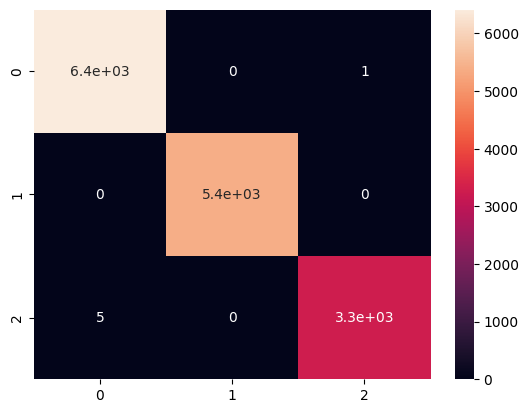

In [29]:
sns.heatmap(cf_matrix,annot=True)

#### Feature Importance Analysis

In [31]:
x_importance = test_stop_time_class
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(x_importance)

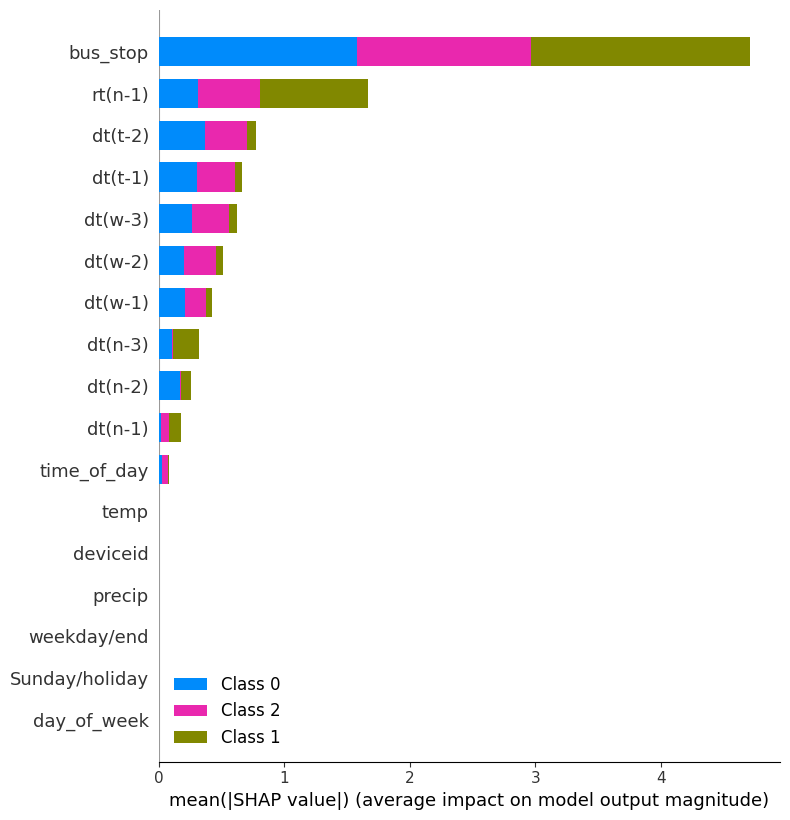

In [32]:
shap.summary_plot(shap_values,x_importance,plot_type="bar")

In [33]:
classifier.save_model('../../models/stop_type_classifier_model.json')